### Optimal control of the noisy Hopf model


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')
    os.chdir('..')
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.hopf import HopfModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.optimal_control import oc_hopf

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

# We define colors for later convenience
color_x = 'red'
color_y = 'blue'

In [2]:
# We import the model
hopf = HopfModel()
hopf.params.sigma_ou = 0.

# Some parameters to define stimulation signals
dt = hopf.params["dt"]
duration = 40.
amplitude = 1.
period = duration/4.

# We define a "zero-input", and a sine-input
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,1:-2] = np.sin(2.*np.pi*np.arange(0,duration-0.2, dt)/period) # other functions or random values can be used as well

# We set the duration of the simulation and the initial values
hopf.params["duration"] = duration
x_init = 0.
y_init = 0.
hopf.params["xs_init"] = np.array([[x_init]])
hopf.params["ys_init"] = np.array([[y_init]])

In [3]:
# define plot function for later convenience
def plot_singlenode(state, target, control, input, weight_array=[]):
    fig, ax = plt.subplots( 3,1, figsize=(8,6), constrained_layout=True)

    # Plot the target (dashed line) and unperturbed activity
    t_array = np.arange(0, duration+dt, dt)

    ax[0].plot(t_array, state[0,0,:], label="x", color=color_x)
    ax[0].plot(t_array, state[0,1,:], label="y", color=color_y)
    ax[0].plot(t_array, target[0,0,:], linestyle='dashed', label="Target x", color=color_x)
    ax[0].plot(t_array, target[0,1,:], linestyle='dashed', label="Target y", color=color_y)
    ax[0].legend()
    ax[0].set_title("Activity without stimulation and target activity")

    # Plot the target control signal (dashed line) and "initial" zero control signal
    ax[1].plot(t_array, control[0,0,:], label="stimulation x", color=color_x)
    ax[1].plot(t_array, control[0,1,:], label="stimulation y", color=color_y)
    ax[1].plot(t_array, input[0,0,:], linestyle='dashed', label="input x", color=color_x)
    ax[1].plot(t_array, input[0,1,:], linestyle='dashed', label="input y", color=color_y)
    ax[1].legend()
    ax[1].set_title("Active stimulation and input stimulation")

    ax[2].plot(weight_array)
    ax[2].set_title("Cost throughout optimization.")

    plt.show()

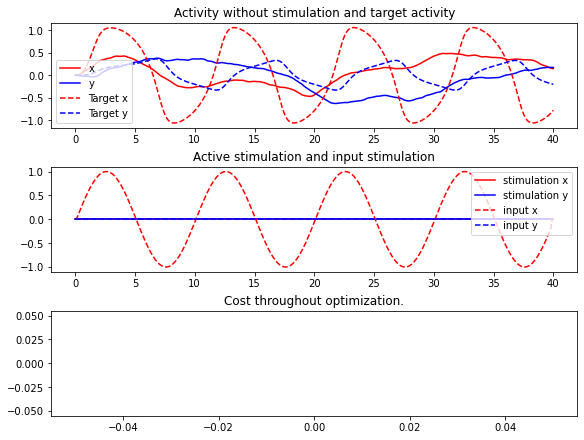

In [4]:
# We set the stimulus in x and y variables, and run the simulation in a noise-free system
hopf.params["x_ext"] = input
hopf.params["y_ext"] = zero_input
hopf.run()

# Define the result of the stimulation as target
target = np.concatenate((np.concatenate( (hopf.params["xs_init"], hopf.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (hopf.x, hopf.y), axis=1)), axis=2)
target_input = np.concatenate( (input,zero_input), axis=0)[np.newaxis,:,:]

# Remove stimuli and re-run the simulation with noise
# Change sigma_ou_parameter to adjust the noise strength
hopf.params['sigma_ou'] = 0.1
hopf.params['tau_ou'] = 1.
hopf.params["x_ext"] = zero_input
hopf.params["y_ext"] = zero_input
control = np.concatenate( (zero_input,zero_input), axis=0)[np.newaxis,:,:]
hopf.run()

# combine initial value and simulation result to one array
state = np.concatenate((np.concatenate( (hopf.params["xs_init"], hopf.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (hopf.x, hopf.y), axis=1)), axis=2)

plot_singlenode(state, target, control, target_input)

Compute control for a noisy system


ERROR:root:nan in model output!
ERROR:root:nan in model output!


diverging model output, decrease step size to  5.0
diverging model output, decrease step size to  2.5
Mean cost in iteration 10: 6.53925660701085
Mean cost in iteration 20: 0.5370218146236114
Mean cost in iteration 30: 0.07867811498230276
Mean cost in iteration 40: 0.023499846803182806
Mean cost in iteration 50: 0.0082642146997781
Mean cost in iteration 60: 0.003611581405037256
Mean cost in iteration 70: 0.0018542502994599581
Mean cost in iteration 80: 0.0012025183554710641
Mean cost in iteration 90: 0.0009396085689730746
Mean cost in iteration 100: 0.0007590747981351216


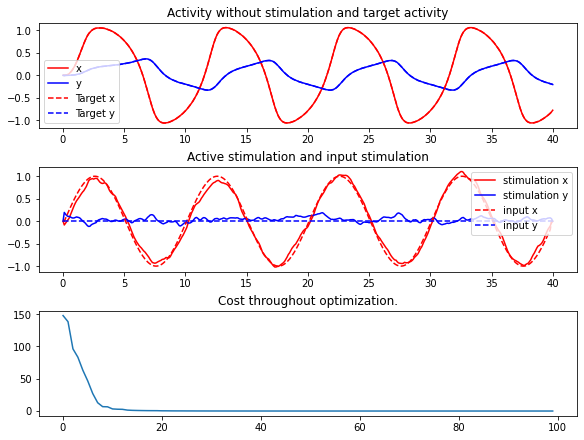

In [5]:
# We load the optimal control class
# print array (optinal parameter) defines, for which iterations intermediate results will be printed
# Parameters will be taken from the input model
hopf.params["x_ext"] = zero_input
hopf.params["y_ext"] = zero_input
hopf_controlled = oc_hopf.OcHopf(hopf, target, w_p=1, w_2=0, print_array=np.arange(0,101,10),
                              M=20, M_validation=500, validate_per_step=True, method='3')

# We run 100 iterations of the optimal control gradient descent algorithm
hopf_controlled.optimize(100)

state = hopf_controlled.get_xs()
control = hopf_controlled.control

plot_singlenode(state, target, control, target_input, hopf_controlled.cost_history)
